# 📖 Sistem Rekomendasi Buku

Notebook ini bertujuan untuk membangun sebuah sistem rekomendasi buku dengan mencoba dua pendekatan yang berbeda:
- **Content-Based Filtering**: merekomendasikan buku berdasarkan kemiripan konten/atribut (seperti kategori).
- **Collaborative Filtering**: merekomendasikan berdasarkan preferensi pengguna serupa.

Pengembangan sistem ini penting karena:
1. Di tengah jutaan pilihan buku yang tersedia, pembaca seringkali kesulitan menemukan bacaan baru yang sesuai dengan selera mereka.
2. Sistem rekomendasi membantu menjembatani kesenjangan ini dengan menyajikan saran yang relevan dan dipersonalisasi.
3. Meningkatkan pengalaman membaca dengan memperkenalkan pengguna pada buku-buku yang mungkin mereka sukai namun belum pernah mereka temukan sebelumnya.

# Import Library

Pada bagian ini dilakukan import library yang diperlukan untuk pengembangan sistem rekomendasi Conten Based Filtering dan Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict

from sklearn.metrics import confusion_matrix, classification_report

Pada bagian ini, semua *library* yang diperlukan untuk proyek dimuat. Ini mencakup *library* fundamental untuk analisis dan manipulasi data seperti **`pandas`** dan **`numpy`**, serta **`matplotlib`** dan **`seaborn`** untuk visualisasi. Untuk membangun model, digunakan **`scikit-learn`** yang berfungsi untuk mengekstraksi fitur teks (TF-IDF) dan menghitung metrik evaluasi, serta **`TensorFlow`** dan **`Keras`** untuk membangun arsitektur model rekomendasi berbasis *deep learning*.

# Load Data

Pada tahap ini, dataset **Book-Crossing** dari Kaggle dimuat sebagai dasar proyek. Kita akan menggunakan file `Preprocessed_data.csv` yang berisi informasi rating, pengguna, dan metadata buku. Sumber dataset dapat diakses melalui [Kaggle](https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset).

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"otanrafif","key":"af55e12bf6b939ffa5db7fc283b165a9"}'}

Kode ini berfungsi untuk mengunggah file dari komputer lokal ke lingkungan Google Colab. File yang diunggah adalah `kaggle.json`, yang berisi kredensial (kunci API) untuk melakukan autentikasi dengan platform Kaggle. Langkah ini merupakan prasyarat agar dataset dapat diunduh secara langsung ke dalam notebook menggunakan Kaggle API.

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ruchi798/bookcrossing-dataset
!unzip bookcrossing-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset
License(s): CC0-1.0
  0% 0.00/76.1M [00:00<?, ?B/s]
100% 76.1M/76.1M [00:00<00:00, 809MB/s]
Archive:  bookcrossing-dataset.zip
  inflating: Book reviews/Book reviews/BX-Book-Ratings.csv  
  inflating: Book reviews/Book reviews/BX-Users.csv  
  inflating: Book reviews/Book reviews/BX_Books.csv  
  inflating: Books Data with Category Language and Summary/Preprocessed_data.csv  


Setelah file `kaggle.json` diunggah, serangkaian perintah ini dijalankan untuk mengonfigurasi kredensial API. File tersebut dipindahkan ke direktori standar `~/.kaggle` dan hak aksesnya diubah untuk keamanan. Setelah konfigurasi selesai, dataset **Book-Crossing** diunduh secara otomatis dari Kaggle, dan file ZIP yang dihasilkan kemudian diekstrak untuk mengakses data CSV yang akan digunakan dalam proyek ini.

In [4]:
rating = pd.read_csv('/content/Books Data with Category Language and Summary/Preprocessed_data.csv', encoding='latin1', on_bad_lines='skip')
book = rating['isbn'].nunique()
user = rating['user_id'].nunique()

print('Jumlah data rating yang ada:', len(rating))
print('Jumlah data user yang ada:', (user))
print('Jumlah data buku yang ada:', (book))

Jumlah data rating yang ada: 1031175
Jumlah data user yang ada: 92107
Jumlah data buku yang ada: 270170


Pada langkah ini, file `Preprocessed_data.csv` dimuat ke dalam sebuah DataFrame pandas untuk dianalisis. Setelah data berhasil dimuat, dilakukan perhitungan skala awal untuk memahami volume data. Hasilnya menunjukkan bahwa dataset ini sangat besar, mencakup total **1.031.175** data rating dari **92.107** pengguna unik terhadap **270.170** buku yang berbeda. Skala data yang besar ini memberikan gambaran awal tentang kompleksitas dan kepadatan (*sparsity*) dari dataset yang akan digunakan.

In [5]:
book_sample = rating.sample(n=100000, random_state=42)
list_isbn_subset = book_sample['isbn'].unique()

print(f"Jumlah buku unik setelah sampling: {len(list_isbn_subset)}")
print("-" * 50)

# Memfilter DataFrame rating utama berdasarkan ISBN yang ada di dalam subset
rating_filtered = rating[rating['isbn'].isin(list_isbn_subset)]
print(f"Jumlah data rating setelah difilter: {len(rating_filtered)}")
print("-" * 50)

# Menghitung jumlah user unik dari data rating yang telah difilter
user_count_filtered = rating_filtered['user_id'].nunique()
print(f"Jumlah data user setelah difilter: {user_count_filtered}")
print("-" * 50)

# Menampilkan hasil akhir
print("\n--- HASIL AKHIR PENGURANGAN DATASET ---")
print(f"Jumlah data buku unik: {len(list_isbn_subset)}")
print(f"Jumlah data rating: {len(rating_filtered)}")
print(f"Jumlah data user unik: {user_count_filtered}")
print("\nDataset berhasil dikurangi dan siap untuk analisis selanjutnya!")

Jumlah buku unik setelah sampling: 58949
--------------------------------------------------
Jumlah data rating setelah difilter: 617642
--------------------------------------------------
Jumlah data user setelah difilter: 71675
--------------------------------------------------

--- HASIL AKHIR PENGURANGAN DATASET ---
Jumlah data buku unik: 58949
Jumlah data rating: 617642
Jumlah data user unik: 71675

Dataset berhasil dikurangi dan siap untuk analisis selanjutnya!


Mengingat skala dataset yang sangat besar dan keterbatasan sumber daya komputasi (RAM), dilakukan proses pengurangan data untuk menciptakan subset yang lebih mudah dikelola. Proses ini dimulai dengan mengambil sampel acak sebanyak **100.000** data rating. Dari sampel tersebut, diidentifikasi buku-buku unik yang kemudian digunakan untuk memfilter dataset utama, sehingga semua rating yang terkait dengan buku-buku tersebut tetap dipertahankan. Hasilnya adalah dataset yang lebih fokus dengan **617.642** rating untuk **58.949** buku unik dari **71.675** pengguna, yang siap untuk analisis dan pemodelan lebih lanjut.

# Exploratory Data Analysis (EDA)

Pada tahap *Exploratory Data Analysis* (EDA) ini, dilakukan eksplorasi awal terhadap data untuk memahami struktur, kondisi, dan karakteristik dari setiap variabel kunci. Analisis ini membantu dalam mengidentifikasi pola distribusi, seperti demografi pengguna dan popularitas buku, serta potensi masalah data yang dapat mempengaruhi performa model. Proses ini merupakan langkah esensial sebelum melangkah ke tahap pemodelan, karena kualitas dan pemahaman terhadap data input akan sangat menentukan kualitas rekomendasi yang dihasilkan.

In [6]:
rating_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 617642 entries, 0 to 1031163
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           617642 non-null  int64  
 1   user_id              617642 non-null  int64  
 2   location             617642 non-null  object 
 3   age                  617642 non-null  float64
 4   isbn                 617642 non-null  object 
 5   rating               617642 non-null  int64  
 6   book_title           617642 non-null  object 
 7   book_author          617642 non-null  object 
 8   year_of_publication  617642 non-null  float64
 9   publisher            617642 non-null  object 
 10  img_s                617642 non-null  object 
 11  img_m                617642 non-null  object 
 12  img_l                617642 non-null  object 
 13  Summary              617642 non-null  object 
 14  Language             617642 non-null  object 
 15  Category             

Setelah dataset dikurangi, metode `.info()` digunakan untuk mendapatkan ringkasan teknis dari DataFrame `rating_filtered`. Hasilnya mengonfirmasi bahwa data kini terdiri dari **617.642** entri dengan **19** kolom fitur. Analisis ini juga memperlihatkan tipe data dari setiap kolom (seperti `int64`, `float64`, dan `object`) dan yang terpenting, mengidentifikasi adanya *missing values* (nilai kosong) pada kolom-kolom terkait lokasi seperti `city`, `state`, dan `country`, yang mungkin memerlukan penanganan lebih lanjut.

In [7]:
rating_filtered.head()

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada
3,3,11676,"n/a, n/a, n/a",34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],NaN,NaN,NaN
4,4,41385,"sudbury, ontario, canada",34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],sudbury,ontario,canada


Untuk mendapatkan gambaran visual mengenai isi dan struktur data setelah proses filtering, metode `.head()` digunakan untuk menampilkan lima baris pertama dari DataFrame. Tampilan sampel ini membantu memverifikasi bahwa kolom-kolom kunci seperti `user_id`, `isbn`, `rating`, dan `book_title` telah termuat dengan benar. Selain itu, inspeksi visual ini juga secara langsung memperlihatkan beberapa karakteristik data, seperti format kolom `Category` dan adanya nilai kosong (`NaN`) pada beberapa entri lokasi, yang mengonfirmasi temuan dari analisis `.info()` sebelumnya.

### Distribusi Geografis

In [8]:
jumlah_user = rating_filtered['user_id'].nunique()
jumlah_location = rating_filtered['location'].nunique()
print(f"Terdapat {jumlah_user} user yang berasal dari {jumlah_location} lokasi berbeda: \n Lokasi:", rating_filtered['location'].unique())

Terdapat 71675 user yang berasal dari 18350 lokasi berbeda: 
 Lokasi: ['stockton, california, usa' 'timmins, ontario, canada'
 'ottawa, ontario, canada' ... 'bolligen, bern,'
 'copenhagen s, sjÃ¦lland, denmark' 'grasse, alpes-maritimes, france']


Untuk memahami sebaran geografis pengguna dalam dataset, dilakukan analisis terhadap kolom `location`. Hasilnya menunjukkan bahwa **71.675** pengguna unik berasal dari **18.350** lokasi yang berbeda. Tingginya jumlah lokasi ini menandakan bahwa basis pengguna sangat beragam dan tersebar secara internasional, mencakup berbagai kota dan negara di seluruh dunia, tidak terkonsentrasi pada satu wilayah tertentu.

### Analisis Univariat

#### Location


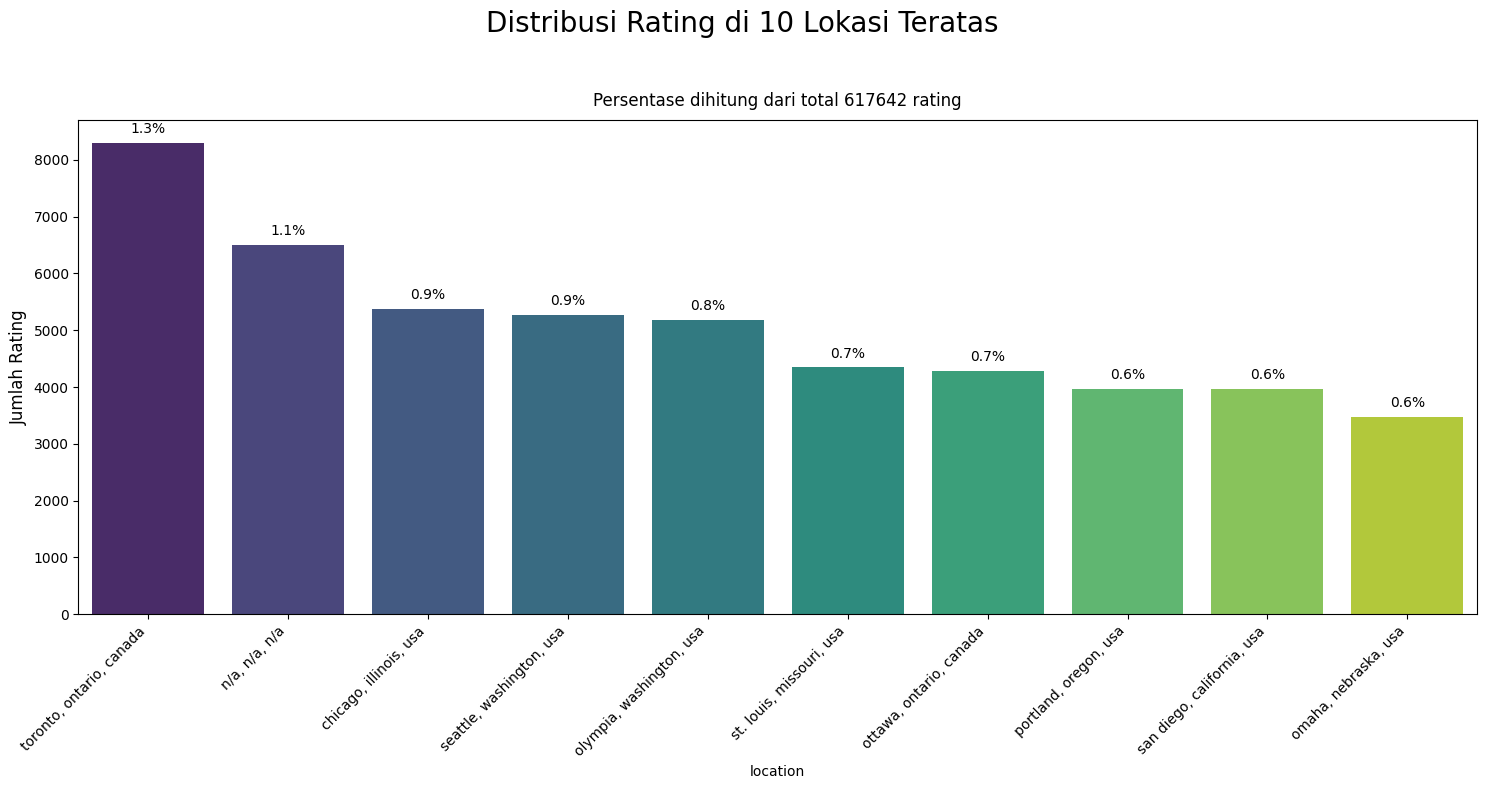

In [9]:
df = rating_filtered.copy()

top_10_locations = df['location'].value_counts().head(10).index

df_top10 = df[df['location'].isin(top_10_locations)]

plt.figure(figsize=(15, 8))
plt.suptitle('Distribusi Rating di 10 Lokasi Teratas', y=0.98, fontsize=20)

ax = sns.countplot(data=df_top10, x='location', palette='viridis',
                   order=top_10_locations)


total_awal = len(df)
for p in ax.patches:
    percentage = 100 * p.get_height() / total_awal
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 5),
                textcoords='offset points')

plt.title(f'Persentase dihitung dari total {total_awal} rating', pad=10, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Jumlah Rating', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Diagram batang ini menggambarkan distribusi frekuensi rating berdasarkan 10 lokasi pengguna teratas. Dari total 617.642 rating, lokasi dengan kontribusi tertinggi adalah **Toronto, Ontario, Kanada**, yang menyumbang sekitar **1.3%** dari total rating. Menariknya, lokasi kedua teratas adalah **'n/a, n/a, n/a' (1.1%)**, yang mengindikasikan adanya data lokasi yang tidak valid dalam jumlah yang signifikan. Secara umum, distribusi ini menunjukkan bahwa tidak ada lokasi yang mendominasi secara kuat, di mana bahkan 10 lokasi teratas hanya menyumbang persentase yang sangat kecil dari keseluruhan data, yang mengonfirmasi bahwa basis pengguna sangat tersebar secara geografis.

#### Age


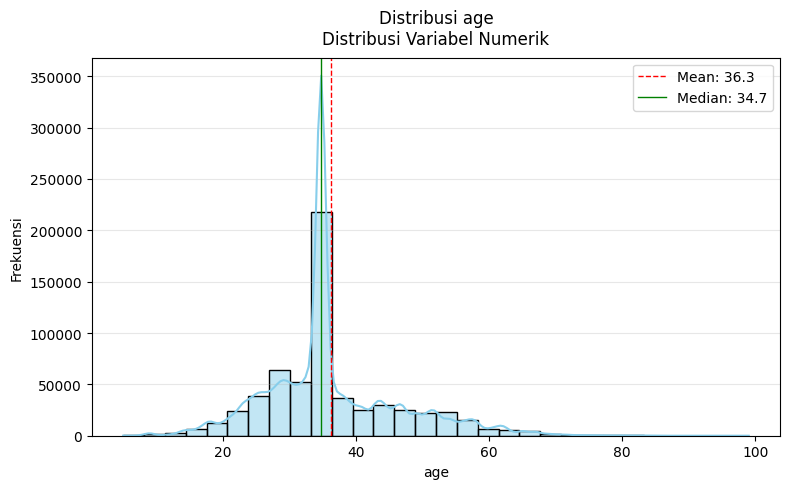

In [10]:
numerical_columns = ['age']
df = rating_filtered.copy()
plt.figure(figsize=(8, 5))

col = numerical_columns[0]
ax = sns.histplot(data=df, x=col, kde=True, bins=30, color='skyblue')

mean_val = df[col].mean()
median_val = df[col].median()
plt.axvline(mean_val, color='r', ls='--', lw=1, label=f'Mean: {mean_val:.1f}')
plt.axvline(median_val, color='g', lw=1, label=f'Median: {median_val:.1f}')

plt.title(f'Distribusi {col}\nDistribusi Variabel Numerik', pad=10)
plt.xlabel(col)
plt.ylabel('Frekuensi')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Histogram ini menampilkan distribusi frekuensi untuk variabel `age` (usia) pengguna. Hal yang paling menonjol adalah adanya puncak frekuensi yang sangat tinggi di sekitar usia 34.7 tahun, yang juga merupakan nilai median. Puncak ini kemungkinan besar merupakan hasil dari imputasi nilai yang hilang pada dataset asli. Di luar puncak tersebut, distribusi data cenderung miring ke kanan (*positively skewed*), yang dikonfirmasi oleh nilai *mean* (rata-rata) sebesar **36.3** yang lebih besar dari *median* **34.7**. Ini mengindikasikan bahwa mayoritas pengguna berada pada rentang usia dewasa muda hingga paruh baya.

#### Rating

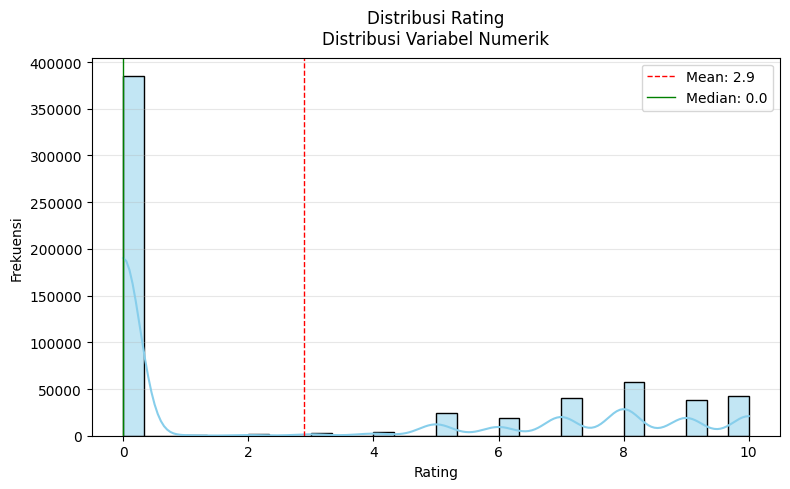

In [11]:
df = rating_filtered.copy()

plt.figure(figsize=(8, 5))
ax = sns.histplot(data=df, x='rating', kde=True, bins=30, color='skyblue')

mean_val = df['rating'].mean()
median_val = df['rating'].median()
plt.axvline(mean_val, color='r', ls='--', lw=1, label=f'Mean: {mean_val:.1f}')
plt.axvline(median_val, color='g', lw=1, label=f'Median: {median_val:.1f}')

plt.title('Distribusi Rating\nDistribusi Variabel Numerik', pad=10)
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Visualisasi ini menampilkan distribusi frekuensi untuk variabel `rating`. Hal yang paling signifikan dari grafik ini adalah puncak frekuensi yang sangat besar pada **rating 0**, yang menunjukkan mayoritas interaksi dalam dataset ini bersifat implisit (pengguna berinteraksi dengan buku tanpa memberikan skor). Untuk rating eksplisit (nilai 1-10), distribusinya cenderung miring ke kiri, dengan lebih banyak pengguna memberikan rating tinggi (7-10). Dominasi rating 0 ini juga menjelaskan mengapa nilai **median** adalah **0.0**, sementara nilai **mean** (rata-rata) tertarik ke **2.9** oleh adanya rating eksplisit. Temuan ini mengindikasikan bahwa rating 0 perlu ditangani secara khusus sebelum pemodelan.

#### Book Author

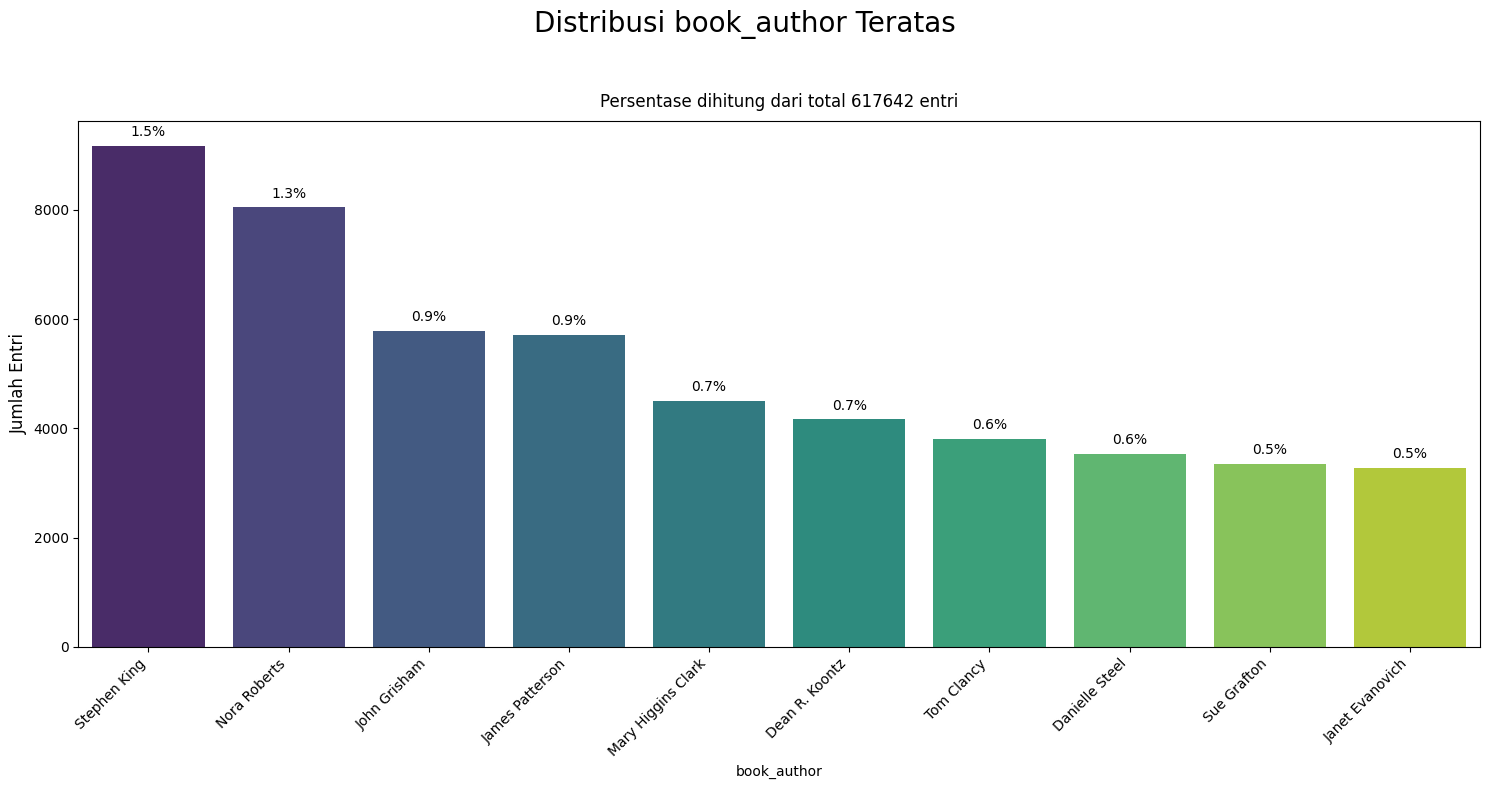

In [12]:
def plot_categorical_distribution(df, column_name, top_n=10):
    top_n_categories = df[column_name].value_counts().head(top_n).index
    df_topn = df[df[column_name].isin(top_n_categories)]

    plt.figure(figsize=(15, 8))
    plt.suptitle(f'Distribusi {column_name} Teratas', y=0.98, fontsize=20)

    ax = sns.countplot(data=df_topn, x=column_name, palette='viridis', order=top_n_categories)

    total_awal = len(df)
    for p in ax.patches:
        percentage = 100 * p.get_height() / total_awal
        ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

    plt.title(f'Persentase dihitung dari total {total_awal} entri', pad=10, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Jumlah Entri', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_categorical_distribution(df, 'book_author')


Untuk memahami popularitas penulis dalam dataset, diagram batang ini memvisualisasikan 10 penulis dengan jumlah entri (rating) buku terbanyak. Hasilnya menunjukkan bahwa **Stephen King** menempati posisi teratas dengan kontribusi sebesar **1.5%** dari total entri, diikuti oleh penulis populer lainnya seperti **Nora Roberts (1.3%)**, **John Grisham (0.9%)**, dan **James Patterson (0.9%)**. Distribusi ini mengidentifikasi penulis-penulis paling produktif dan paling sering dibaca di kalangan pengguna dalam dataset ini, yang didominasi oleh penulis fiksi populer.

#### Year of Publication

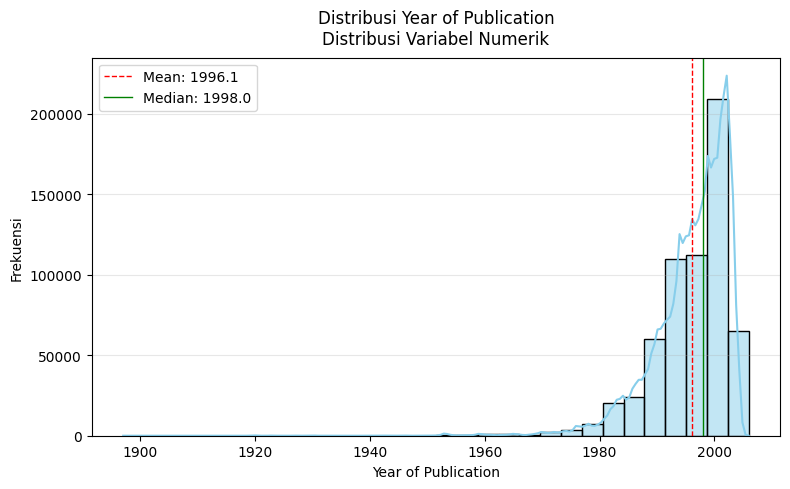

In [13]:
plt.figure(figsize=(8, 5))
ax = sns.histplot(data=df, x='year_of_publication', kde=True, bins=30, color='skyblue')

mean_val = df['year_of_publication'].mean()
median_val = df['year_of_publication'].median()
plt.axvline(mean_val, color='r', ls='--', lw=1, label=f'Mean: {mean_val:.1f}')
plt.axvline(median_val, color='g', lw=1, label=f'Median: {median_val:.1f}')

plt.title('Distribusi Year of Publication\nDistribusi Variabel Numerik', pad=10)
plt.xlabel('Year of Publication')
plt.ylabel('Frekuensi')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Histogram berikut menampilkan distribusi frekuensi buku berdasarkan tahun publikasi. Grafik ini menunjukkan distribusi yang sangat miring ke kiri (*negatively skewed*), dengan puncak frekuensi yang tajam terjadi pada periode akhir 1990-an hingga awal 2000-an. Kecenderungan ini dikonfirmasi oleh nilai *mean* (rata-rata) sebesar **1996.1** yang lebih rendah dari nilai *median* **1998.0**. Hal ini mengindikasikan bahwa sebagian besar buku yang diberi rating dalam dataset ini adalah buku-buku modern yang terbit dalam beberapa dekade terakhir.

#### Publisher

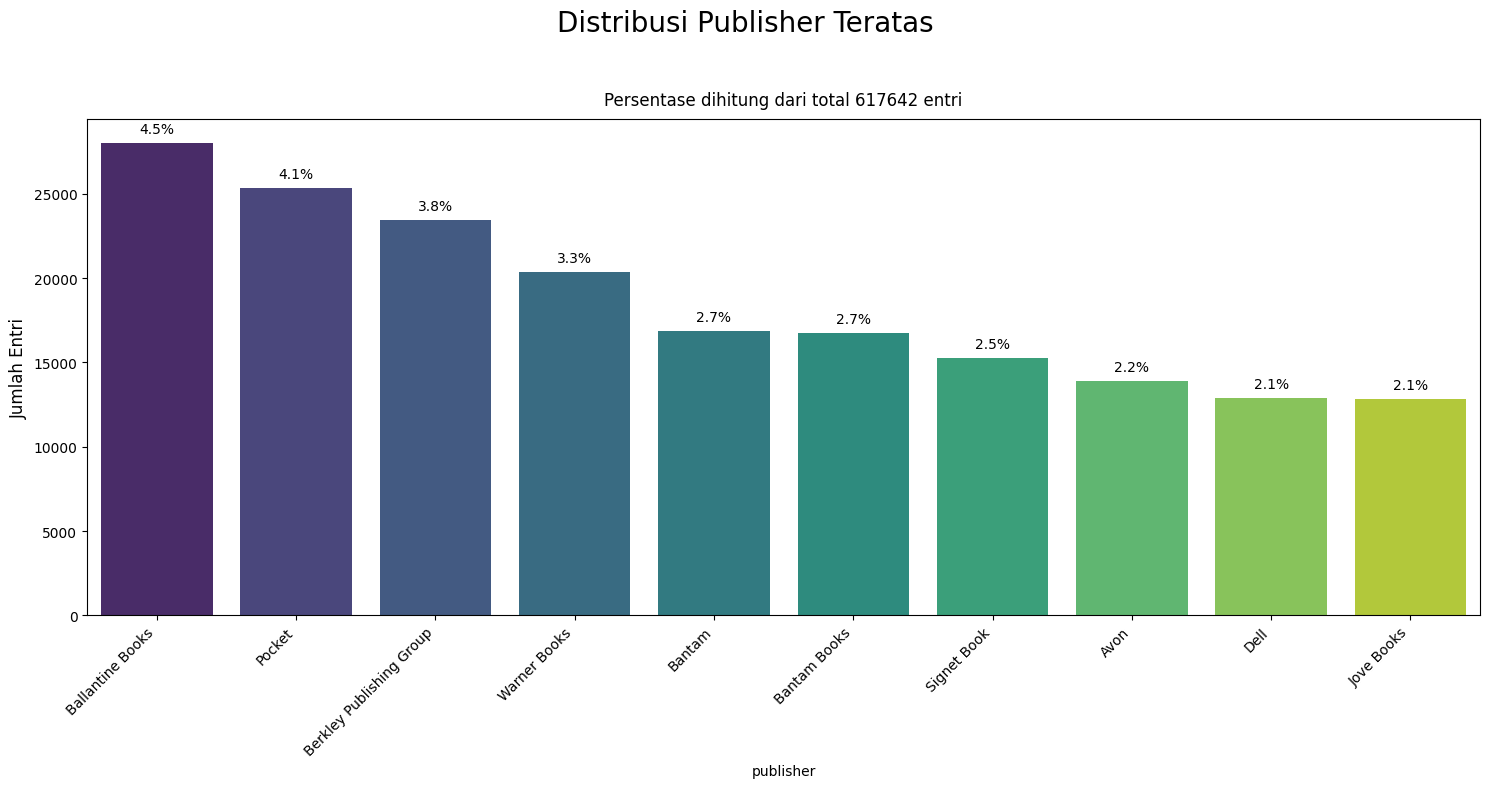

In [14]:
top_10_publishers = df['publisher'].value_counts().head(10).index
df_top10_publishers = df[df['publisher'].isin(top_10_publishers)]

plt.figure(figsize=(15, 8))
plt.suptitle('Distribusi Publisher Teratas', y=0.98, fontsize=20)

ax = sns.countplot(data=df_top10_publishers, x='publisher', palette='viridis',
                   order=top_10_publishers)

total_awal = len(df)
for p in ax.patches:
    percentage = 100 * p.get_height() / total_awal
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 5),
                textcoords='offset points')

plt.title(f'Persentase dihitung dari total {total_awal} entri', pad=10, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Jumlah Entri', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Diagram batang berikut menganalisis distribusi 10 penerbit (*publisher*) yang paling sering muncul dalam data rating. Dari hasil visualisasi, terlihat bahwa **Ballantine Books** merupakan penerbit yang paling dominan dengan **4.5%** dari total entri, diikuti oleh penerbit besar lainnya seperti **Pocket (4.1%)** dan **Berkley Publishing Group (3.8%)**. Distribusi ini menunjukkan adanya konsentrasi pada beberapa penerbit besar yang umumnya menerbitkan buku-buku pasar massal, yang sejalan dengan popularitas penulis fiksi yang telah dianalisis sebelumnya.

#### Language

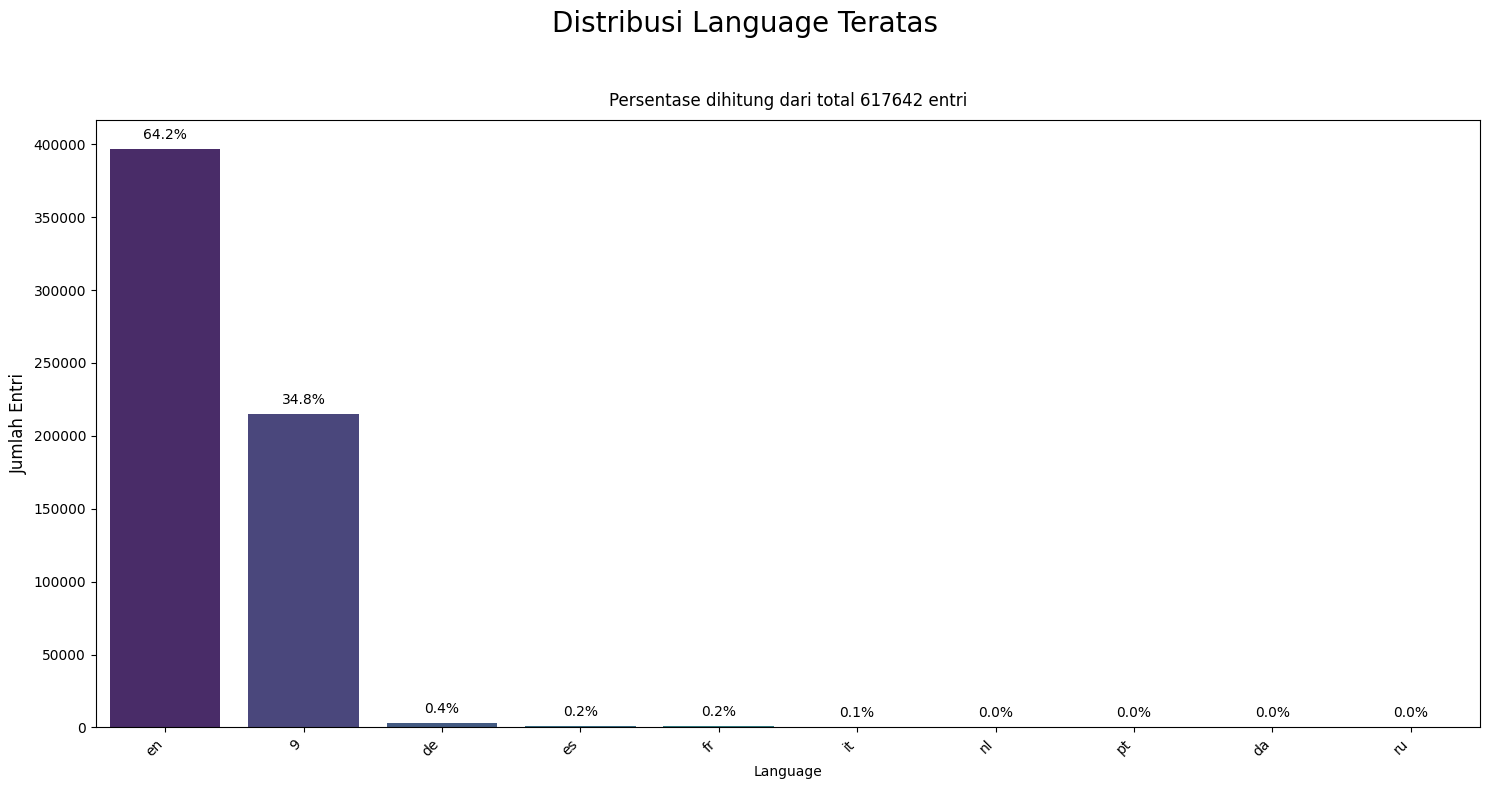

In [15]:
top_10_languages = df['Language'].value_counts().head(10).index
df_top10_languages = df[df['Language'].isin(top_10_languages)]

plt.figure(figsize=(15, 8))
plt.suptitle('Distribusi Language Teratas', y=0.98, fontsize=20)

ax = sns.countplot(data=df_top10_languages, x='Language', palette='viridis',
                   order=top_10_languages)

total_awal = len(df)
for p in ax.patches:
    percentage = 100 * p.get_height() / total_awal
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 5),
                textcoords='offset points')

plt.title(f'Persentase dihitung dari total {total_awal} entri', pad=10, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Jumlah Entri', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Grafik ini memvisualisasikan distribusi 10 bahasa (*Language*) teratas dalam dataset. Hasil analisis menunjukkan bahwa bahasa Inggris (`en`) mendominasi secara absolut, mencakup **64.2%** dari keseluruhan entri. Selain itu, teridentifikasi adanya data anomali yang signifikan, di mana nilai **'9'** muncul sebagai 'bahasa' kedua teratas dengan persentase **34.8%**, yang mengindikasikan adanya masalah kualitas data yang perlu ditangani. Bahasa-bahasa lainnya memiliki kontribusi yang sangat kecil, menegaskan bahwa dataset ini mayoritas besar berisi buku-buku berbahasa Inggris.

#### Category

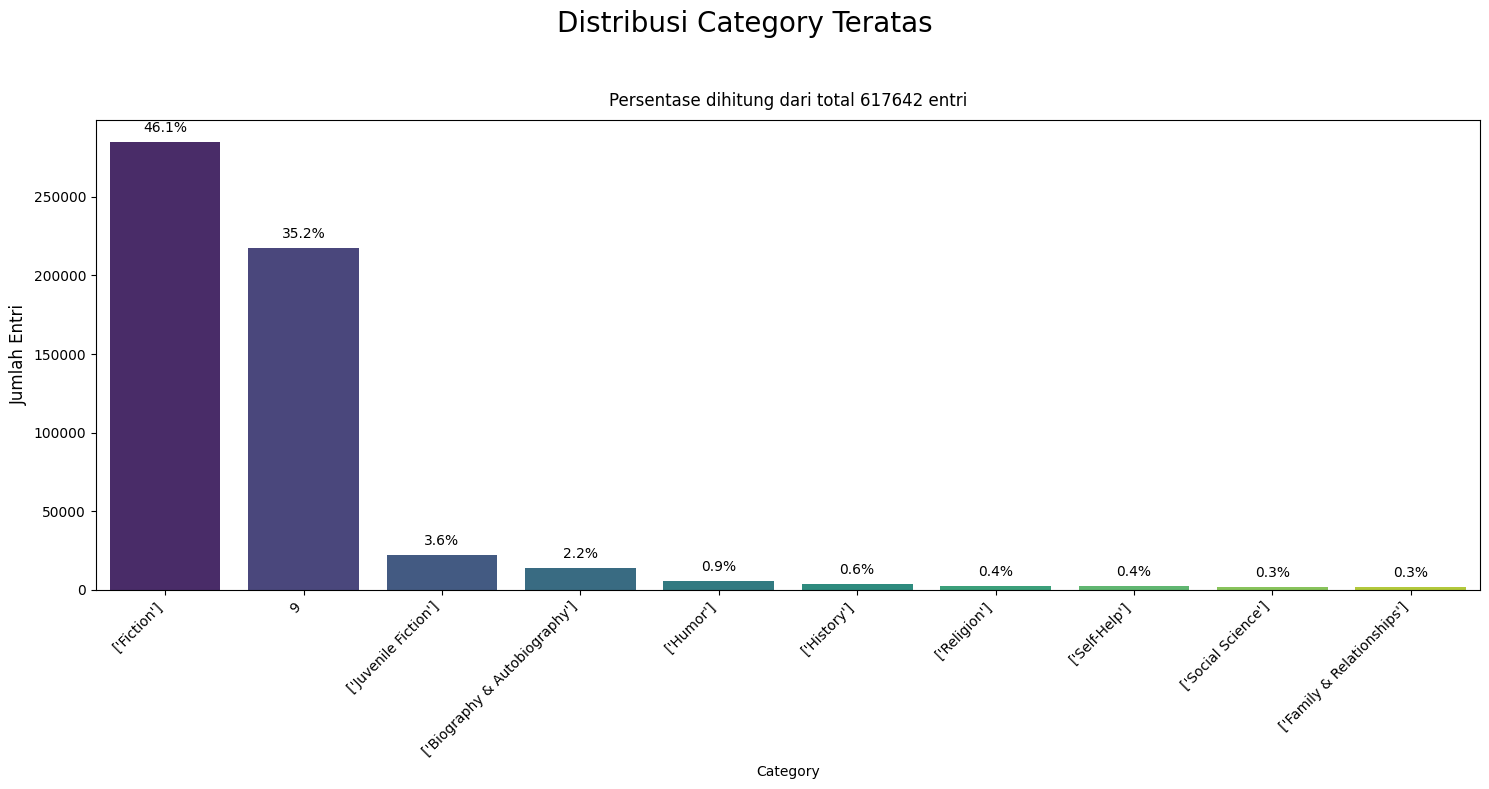

In [16]:
top_10_categories = df['Category'].value_counts().head(10).index
df_top10_categories = df[df['Category'].isin(top_10_categories)]

plt.figure(figsize=(15, 8))
plt.suptitle('Distribusi Category Teratas', y=0.98, fontsize=20)

ax = sns.countplot(data=df_top10_categories, x='Category', palette='viridis',
                   order=top_10_categories)

total_awal = len(df)
for p in ax.patches:
    percentage = 100 * p.get_height() / total_awal
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 5),
                textcoords='offset points')

plt.title(f'Persentase dihitung dari total {total_awal} entri', pad=10, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Jumlah Entri', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Visualisasi ini menganalisis distribusi frekuensi dari 10 kategori (`Category`) buku yang paling sering diberi rating. Hasilnya menunjukkan bahwa kategori **Fiksi (`['Fiction']`)** memiliki dominasi yang sangat kuat, mencakup **46.1%** dari total data. Konsisten dengan temuan pada fitur bahasa, ditemukan juga data anomali di mana nilai **'9'** menempati posisi kedua teratas dengan persentase **35.2%**. Format kategori yang masih berbentuk *string list* (contoh: `['Fiction']`) dan adanya nilai anomali ini menegaskan perlunya tahap pembersihan data yang akan dilakukan selanjutnya.

# Data Preparation


Sebelum membangun model rekomendasi, data perlu diproses terlebih dahulu untuk memastikan kualitas dan konsistensinya. Tahap persiapan data ini meliputi beberapa langkah penting:

* **Pembersihan dan Standardisasi Fitur Kategorikal:**
    Membersihkan dan menyeragamkan format pada kolom `Category` untuk menghilangkan karakter yang tidak diinginkan dan data anomali (seperti nilai '9').

* **Penanganan Rating Implisit dan Duplikat:**
    Memfilter rating bernilai 0 yang bersifat implisit dan menghapus data duplikat untuk memastikan data rating yang digunakan adalah rating eksplisit dan unik.

* **Seleksi Fitur:**
    Memilih kolom-kolom yang relevan (`user_id`, `isbn`, `rating`, `book_title`, `Category`) untuk kedua model yang akan dibangun.

* **Persiapan Data untuk Content-Based Filtering:**
    Menyiapkan data khusus untuk model CBF dengan mengambil data buku yang unik dan melakukan vektorisasi pada fitur `Category` menggunakan TF-IDF.

* **Persiapan Data untuk Collaborative Filtering:**
    Melakukan *encoding* pada fitur `user_id` dan `isbn` menjadi indeks integer, menormalisasi nilai rating ke rentang [0, 1], dan membagi dataset menjadi data latih dan data validasi (80:20).

**Mengapa Tahap Ini Penting?**
1.  Memastikan data yang digunakan untuk melatih model akurat dan konsisten.
2.  Mencegah masalah teknis saat pembuatan model, seperti error akibat format data yang tidak sesuai.
3.  Meningkatkan kualitas rekomendasi dengan menghilangkan *noise* dan data yang tidak relevan.

## Standardisasi Format Kategori

In [17]:
rating_filtered['Category'].unique()

array(["['Social Science']", "['Actresses']", "['Medical']", ...,
       "['Questions and answers.']", "['Magnets']", "['Brain damage']"],
      dtype=object)

Langkah pertama dalam standardisasi adalah memeriksa nilai-nilai unik yang ada pada kolom `Category` untuk memahami variasinya. Dengan menggunakan metode `.unique()`, terlihat bahwa format data belum seragam. Banyak kategori yang masih terbungkus dalam format *string list* (contoh: `"['Social Science']"`) dan beberapa mengandung tanda baca yang tidak perlu. Temuan ini menegaskan pentingnya tahap pembersihan untuk menyeragamkan format sebelum data digunakan lebih lanjut.

In [18]:
df_cleaned = rating_filtered.copy()

df_cleaned = df_cleaned[df_cleaned['Category'] != '9'].copy()


langkah selanjutnya, salinan dari DataFrame `rating_filtered` dibuat untuk memastikan integritas data asli. Selanjutnya, dilakukan proses *filtering* untuk menghapus semua baris yang memiliki nilai anomali '9' pada kolom `Category`. Nilai ini sebelumnya telah teridentifikasi dalam tahap EDA sebagai data yang tidak valid. Dengan menghapus baris-baris ini, dataset menjadi lebih bersih dan relevan untuk analisis selanjutnya.

In [19]:
df_cleaned['Category'] = df_cleaned['Category'].str.replace(r"\[|\]|'|\"", "", regex=True)
df_cleaned['Category'] = df_cleaned['Category'].str.replace(" ", "_", regex=False)

print("--- Kategori Unik Setelah Dibersihkan ---")
print(df_cleaned['Category'].unique())

--- Kategori Unik Setelah Dibersihkan ---
['Social_Science' 'Actresses' 'Medical' ... 'Questions_and_answers.'
 'Magnets' 'Brain_damage']


Setelah data anomali dihapus, langkah selanjutnya adalah membersihkan format pada kolom `Category`. Proses ini dilakukan dalam dua tahap: pertama, semua karakter yang tidak diinginkan seperti tanda kurung (`[]`) serta tanda kutip tunggal dan ganda (`' "`) dihapus. Kedua, semua spasi diganti dengan *underscore* (`_`) untuk memastikan setiap nama kategori menjadi satu kesatuan string yang utuh. Langkah-langkah ini menghasilkan nilai kategori yang bersih dan konsisten, yang penting untuk memudahkan pemrosesan pada tahap pemodelan selanjutnya.

In [20]:
df_cleaned = df_cleaned[df_cleaned['rating'] != 0].copy()

Seperti yang teridentifikasi pada tahap EDA, terdapat banyak sekali rating bernilai 0. Rating ini bersifat implisit dan tidak menunjukkan skor penilaian eksplisit dari pengguna (skala 1-10). Oleh karena itu, semua baris dengan rating 0 dihapus dari dataset. Langkah ini sangat penting untuk memastikan model *collaborative filtering* nantinya hanya dilatih pada data rating eksplisit, sehingga dapat memprediksi preferensi pengguna dengan lebih akurat.

## Seleksi Fitur

In [21]:
df_cleaned = df_cleaned[['user_id', 'isbn', 'rating', 'book_title', 'Category']]
df_cleaned

,user_id,isbn,rating,book_title,Category
1,8,0002005018,5,Clara Callan,Actresses
3,11676,0002005018,8,Clara Callan,Actresses
5,67544,0002005018,8,Clara Callan,Actresses
8,116866,0002005018,9,Clara Callan,Actresses
9,123629,0002005018,9,Clara Callan,Actresses
...,...,...,...,...,...
1029964,277965,0785263950,10,"In, But Not Of : A Guide to Christian Ambition",Religion
1030029,278209,0345392698,7,The Perfectionists,Fiction
1030062,278356,0814450598,8,Danger in the Comfort Zone: From Boardroom to ...,Business_&_Economics
1030064,278356,087795979X,10,Lily Pond: Four Years With a Family of Beavers,Science


Pada tahap ini, dilakukan proses seleksi fitur untuk menyederhanakan dataset. Dari 19 kolom yang ada, hanya fitur-fitur yang relevan untuk pembangunan model rekomendasi yang dipertahankan. Fitur-fitur tersebut adalah `user_id`, `isbn`, dan `rating` yang menjadi inti dari *collaborative filtering*, serta `book_title` dan `Category` yang penting untuk *content-based filtering* dan interpretasi hasil. Langkah ini menghasilkan DataFrame yang lebih ringkas dan fokus, yang siap untuk tahap *encoding* dan pemodelan selanjutnya.

## Pengecekan Data Book

In [22]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149289 entries, 1 to 1030611
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     149289 non-null  int64 
 1   isbn        149289 non-null  object
 2   rating      149289 non-null  int64 
 3   book_title  149289 non-null  object
 4   Category    149289 non-null  object
dtypes: int64(2), object(3)
memory usage: 6.8+ MB


Setelah proses pembersihan dan seleksi fitur, dilakukan pengecekan akhir pada DataFrame `df_cleaned` menggunakan metode `.info()`. Pengecekan ini memverifikasi bahwa dataset kini berisi **149.289** entri data dan yang terpenting, **tidak ada lagi nilai yang hilang (*null*)** pada semua kolom. Struktur akhir DataFrame yang terdiri dari 5 kolom (`user_id`, `isbn`, `rating`, `book_title`, `Category`) dengan tipe data yang sesuai telah siap untuk tahap *feature engineering* dan pemodelan selanjutnya.

## Mengatasi Missing Value dan Duplikasi

In [23]:
df_cleaned.isnull().sum()

,0
user_id,0
isbn,0
rating,0
book_title,0
Category,0


Langkah selanjutnya adalah memverifikasi bahwa tidak ada nilai yang hilang (*missing values*) dalam dataset yang telah dibersihkan. Perintah `.isnull().sum()` digunakan untuk menghitung jumlah nilai kosong pada setiap kolom. Sesuai dengan output yang menunjukkan nilai **0** untuk semua kolom, dapat dipastikan bahwa DataFrame `df_cleaned` sudah bebas dari *missing values*. Hal ini penting untuk memastikan tidak akan ada error yang disebabkan oleh data tidak lengkap saat proses pemodelan nanti.

In [24]:
df_cleaned.duplicated().sum()

np.int64(0)

In [25]:
df_cleaned.drop_duplicates(inplace=True)
df_cleaned.duplicated().sum()

np.int64(0)

Selain memeriksa nilai yang hilang, penting juga untuk memastikan tidak ada data duplikat dalam dataset, karena dapat menyebabkan bias pada model. Dengan menggunakan perintah `.duplicated().sum()`, dilakukan pengecekan untuk menghitung jumlah baris yang identik. Hasilnya menunjukkan nilai **0**, yang mengonfirmasi bahwa tidak ada data duplikat dalam DataFrame `df_cleaned` setelah tahap pembersihan sebelumnya. Meskipun demikian, perintah `.drop_duplicates()` tetap dijalankan sebagai langkah preventif untuk menjamin keunikan setiap entri sebelum lanjut ke tahap pemodelan.

## Penyiapan Data Final

In [26]:
preparation = df_cleaned
preparation.sort_values('isbn')

,user_id,isbn,rating,book_title,Category
1,8,0002005018,5,Clara Callan,Actresses
3,11676,0002005018,8,Clara Callan,Actresses
5,67544,0002005018,8,Clara Callan,Actresses
8,116866,0002005018,9,Clara Callan,Actresses
9,123629,0002005018,9,Clara Callan,Actresses
...,...,...,...,...,...
844537,94242,9806053443,8,El ÃÂ¡rbol generoso,Juvenile_Fiction
357711,163621,9871138016,8,Cronica De Una Muerte Anunciada,Colombian_fiction
357710,140168,9871138016,10,Cronica De Una Muerte Anunciada,Colombian_fiction
187620,3326,9972847012,3,Los amigos que perdÃÂ­,Fiction


Sebagai langkah terakhir dalam persiapan data, DataFrame `df_cleaned` yang sudah bersih ditetapkan menjadi variabel `preparation`. Data kemudian diurutkan berdasarkan `isbn` untuk memberikan struktur yang terorganisir. Langkah ini mempermudah tinjauan data dan mempersiapkannya untuk tahap *feature engineering* dan pemodelan yang akan dilakukan selanjutnya. Dengan demikian, dataset akhir yang berisi **149.289** entri rating yang valid dan bersih kini telah siap.

## Persiapan Data untuk Model Content Based Filtering

In [27]:
preparation_CBF = preparation.copy()
preparation_CBF = preparation_CBF.drop_duplicates('isbn')
preparation_CBF

,user_id,isbn,rating,book_title,Category
1,8,0002005018,5,Clara Callan,Actresses
19,35704,0374157065,6,Flu: The Story of the Great Influenza Pandemic...,Medical
31,11676,0399135782,9,The Kitchen God's Wife,Fiction
77,189238,0771074670,6,Nights Below Station Street,Fiction
102,3329,0440234743,8,The Testament,Fiction
...,...,...,...,...,...
1029964,277965,0785263950,10,"In, But Not Of : A Guide to Christian Ambition",Religion
1030029,278209,0345392698,7,The Perfectionists,Fiction
1030062,278356,0814450598,8,Danger in the Comfort Zone: From Boardroom to ...,Business_&_Economics
1030064,278356,087795979X,10,Lily Pond: Four Years With a Family of Beavers,Science


Untuk mempersiapkan data bagi model *Content-Based Filtering*, sebuah salinan dari dataset `preparation` dibuat untuk memastikan data utama tidak berubah. Selanjutnya, data duplikat berdasarkan kolom `isbn` dihapus. Langkah ini krusial karena model *content-based filtering* hanya memerlukan informasi unik dari setiap item (dalam hal ini, buku) untuk dianalisis, bukan data rating dari setiap pengguna yang berbeda. Hasilnya adalah sebuah DataFrame baru yang berisi **25.183** data buku unik, yang kini siap untuk tahap ekstraksi fitur selanjutnya.

### Ekstraksi Informasi Buku

In [28]:
book_id = preparation_CBF['isbn'].tolist()
book_title = preparation_CBF['book_title'].tolist()
book_category = preparation_CBF['Category'].tolist()

print(len(book_id))
print(len(book_title))
print(len(book_category))

25183
25183
25183


Pada tahap ini, fitur-fitur yang relevan untuk *content-based filtering* diekstrak dari DataFrame. Kolom `isbn` (sebagai ID buku), `book_title`, dan `Category` masing-masing diubah menjadi *list* Python. Langkah ini bertujuan untuk memisahkan metadata buku dari informasi rating, sehingga data lebih mudah diolah untuk pembuatan DataFrame baru yang khusus untuk model *content-based*. Output yang menunjukkan panjang ketiga *list* adalah **25.183** mengonfirmasi bahwa semua data telah diekstrak secara konsisten.

In [29]:
book_data = pd.DataFrame({
    'id': book_id,
    'book': book_title,
    'category': book_category
})
book_data

,id,book,category
0,0002005018,Clara Callan,Actresses
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Medical
2,0399135782,The Kitchen God's Wife,Fiction
3,0771074670,Nights Below Station Street,Fiction
4,0440234743,The Testament,Fiction
...,...,...,...
25178,0785263950,"In, But Not Of : A Guide to Christian Ambition",Religion
25179,0345392698,The Perfectionists,Fiction
25180,0814450598,Danger in the Comfort Zone: From Boardroom to ...,Business_&_Economics
25181,087795979X,Lily Pond: Four Years With a Family of Beavers,Science


Setelah fitur-fitur diekstrak menjadi *list*, sebuah DataFrame baru bernama `book_data` dibuat. DataFrame ini memiliki struktur yang sederhana dengan tiga kolom: `id` (berisi ISBN buku), `book` (judul buku), dan `category`. Tujuan dari pembuatan DataFrame ini adalah untuk memfokuskan data pada metadata yang relevan untuk model *content-based filtering*, di mana fitur `category` akan menjadi dasar utama untuk perhitungan kemiripan (*similarity*) antar buku.

### Vektorisasi dengan TF-IDF

Inti dari *content-based filtering* terletak pada kemampuan sistem untuk memahami karakteristik setiap buku. Untuk mencapai ini, diterapkan teknik **TF-IDF** (*Term Frequency-Inverse Document Frequency*) pada kolom `Category`. Proses ini akan mengubah data teks kategori menjadi representasi vektor numerik. Hasilnya adalah sebuah matriks di mana setiap baris merepresentasikan satu buku dan setiap kolom merepresentasikan satu kategori unik. Nilai dalam matriks ini menunjukkan bobot atau pentingnya suatu kategori dalam mendefinisikan sebuah buku.

In [30]:
book_data['category'].unique()

array(['Actresses', 'Medical', 'Fiction', ..., 'Genetic_engineering',
       'AIDS_(Disease)_in_children', 'Grocery_shopping'], dtype=object)

Untuk memahami variasi fitur yang akan divektorisasi, dilakukan pengecekan nilai-nilai unik pada kolom `category`. Hasilnya menunjukkan terdapat ribuan kategori yang sangat beragam dan spesifik. Kategori-kategori ini mencakup topik yang sangat luas, mulai dari genre umum seperti **`Fiction`** dan **`Medical`**, hingga topik yang sangat spesifik seperti **`Actresses`** dan **`Genetic_engineering`**. Keragaman kategori inilah yang akan menjadi dasar bagi model TF-IDF untuk membedakan dan mengukur kemiripan antar buku.

In [31]:
tfidf = TfidfVectorizer()

tfidf_matrix = tfidf.fit_transform(book_data['category'])

tfidf.get_feature_names_out()

array(['1377', '1815', '1900_', ..., 'zanzibar', 'zen_buddhism',
       'zeugen_jehovas_'], dtype=object)

Untuk memproses informasi kategori secara komputasional, teknik TF-IDF diterapkan. Pertama, sebuah objek `TfidfVectorizer` diinisialisasi. Objek ini kemudian digunakan untuk mempelajari kosakata dari seluruh kategori dan sekaligus mentransformasikannya menjadi sebuah matriks TF-IDF melalui metode `.fit_transform()`. Perintah `.get_feature_names_out()` digunakan untuk menampilkan fitur-fitur (kategori unik) yang telah dipelajari oleh model, yang kini menjadi kolom-kolom dari matriks vektor tersebut.

Hasil dari `.get_feature_names_out()` adalah sebuah *array* yang berisi seluruh kosakata kategori unik yang telah dipelajari model. Semua kategori ini telah dinormalisasi ke format *lowercase* (huruf kecil) untuk memastikan konsistensi, sehingga kata seperti 'Fiction' dan 'fiction' diperlakukan sebagai satu fitur yang sama.

In [60]:
tfidf_matrix.shape

(25183, 1727)

Setelah transformasi, dimensi dari `tfidf_matrix` diperiksa menggunakan atribut `.shape`. Hasilnya adalah matriks dengan ukuran **(25183, 1727)**. Angka **25.183** menunjukkan jumlah baris yang sesuai dengan jumlah buku unik dalam dataset. Sementara itu, angka **1.727** adalah jumlah kolom yang merepresentasikan seluruh kategori unik (kosakata) yang berhasil diidentifikasi oleh `TfidfVectorizer`. Matriks inilah yang akan menjadi dasar untuk menghitung kemiripan antar buku.

In [33]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Untuk melihat representasi numerik dari matriks TF-IDF secara langsung, metode `.todense()` digunakan. Metode ini mengubah format matriks dari *sparse* (yang hanya menyimpan nilai non-nol untuk efisiensi memori) menjadi format *dense* (matriks penuh). Outputnya menunjukkan sebuah matriks yang sebagian besar berisi nilai 0. Hal ini wajar terjadi karena setiap buku (baris) hanya akan memiliki nilai TF-IDF non-nol pada kolom-kolom yang sesuai dengan kategorinya yang spesifik, dan akan bernilai 0 untuk ribuan kategori lainnya.

In [34]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=book_data.book
).sample(10, axis=1).sample(10, axis=0)

,terrorism,computer_networks,easy_to_read_materials,deryni_,adopted_children,_watterson,catholic_church,comedians,_vicky_,camels
book,,,,,,,,,,
Last Frontiers on Earth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Garzanti - Gli Elefanti: Blues Di Bay City,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Till We Meet Again,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arms and the Man: A Pleasant Play (Shaw, Bernard, Bernard Shaw Library.)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"The Knight in Screaming Armor (Give Yourself Goosebumps, No 9)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Skin: Talking About Sex, Class & Literature",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Endometriosis Sourcebook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Let Us Prey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Pirate Looks At Fifty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Untuk membuat matriks TF-IDF lebih mudah diinterpretasikan, matriks tersebut dikonversi menjadi sebuah DataFrame pandas. Dalam DataFrame ini, setiap judul buku menjadi indeks baris, setiap kategori unik menjadi nama kolom, dan nilai di dalamnya adalah skor TF-IDF yang telah dihitung. Kode ini kemudian menampilkan sampel acak 10x10 dari DataFrame tersebut untuk memberikan gambaran. Seperti yang terlihat pada output, sebagian besar nilainya adalah 0, yang secara visual menunjukkan sifat *sparse* dari data, di mana setiap buku hanya memiliki skor pada beberapa kategori yang sangat spesifik.

## Persiapan Data untuk Model Collaborative Filtering

### Persiapan Data dan Encoding

In [35]:
df = preparation.copy()
df

,user_id,isbn,rating,book_title,Category
1,8,0002005018,5,Clara Callan,Actresses
3,11676,0002005018,8,Clara Callan,Actresses
5,67544,0002005018,8,Clara Callan,Actresses
8,116866,0002005018,9,Clara Callan,Actresses
9,123629,0002005018,9,Clara Callan,Actresses
...,...,...,...,...,...
1029964,277965,0785263950,10,"In, But Not Of : A Guide to Christian Ambition",Religion
1030029,278209,0345392698,7,The Perfectionists,Fiction
1030062,278356,0814450598,8,Danger in the Comfort Zone: From Boardroom to ...,Business_&_Economics
1030064,278356,087795979X,10,Lily Pond: Four Years With a Family of Beavers,Science


Tahap pertama dalam persiapan untuk model *collaborative filtering* adalah dengan membuat salinan DataFrame `preparation` yang telah bersih ke dalam variabel baru bernama `df`. Langkah ini bertujuan untuk menjaga integritas data asli, sekaligus menyediakan *working copy* yang khusus untuk diproses lebih lanjut sesuai kebutuhan model. Output yang ditampilkan mengonfirmasi bahwa DataFrame `df` berisi data rating yang siap untuk tahap *encoding* dan normalisasi.

In [36]:
user_ids = df['user_id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
df['user_encoded'] = df['user_id'].map(user_to_user_encoded)

In [37]:
book_ids = df['isbn'].unique().tolist()
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}
df['book_encoded'] = df['isbn'].map(book_to_book_encoded)


Model *deep learning* memerlukan input numerik, sehingga `user_id` dan `isbn` (sebagai ID buku) yang bersifat kategorikal perlu diubah menjadi indeks integer. Untuk itu, dilakukan proses *encoding* dengan membuat *dictionary* yang memetakan setiap ID unik ke indeks integer yang berurutan (misalnya, dari 1 menjadi 0). Hasil *encoding* ini kemudian disimpan dalam kolom baru (`user_encoded` dan `book_encoded`) pada DataFrame, menghasilkan representasi data yang efisien dan siap diproses oleh *embedding layer* pada model.

In [38]:
df.head(5)

,user_id,isbn,rating,book_title,Category,user_encoded,book_encoded
1,8,0002005018,5,Clara Callan,Actresses,0,0
3,11676,0002005018,8,Clara Callan,Actresses,1,0
5,67544,0002005018,8,Clara Callan,Actresses,2,0
8,116866,0002005018,9,Clara Callan,Actresses,3,0
9,123629,0002005018,9,Clara Callan,Actresses,4,0


Setelah proses *encoding* selesai, metode `.head()` dipanggil untuk menampilkan lima baris pertama dari DataFrame. Langkah ini bertujuan untuk memverifikasi secara visual bahwa kolom-kolom baru, yaitu `user_encoded` dan `book_encoded`, telah berhasil ditambahkan. Dari output, terlihat bahwa setiap `user_id` dan `isbn` asli kini memiliki representasi indeks integer yang unik, yang menandakan data telah siap untuk tahap normalisasi dan pembagian data latih.

In [39]:
jumlah_user = df['user_encoded'].nunique()

jumlah_buku = df['book_encoded'].nunique()

min_rating = min(df['rating'])

max_rating = max(df['rating'])

print(f"Jumlah user: {jumlah_user}\nJumlah buku: {jumlah_buku}\nMin Rating: {min_rating}\nMax Rating: {max_rating}")

Jumlah user: 39518
Jumlah buku: 25183
Min Rating: 1
Max Rating: 10


Setelah proses *encoding*, dilakukan perhitungan untuk mendapatkan parameter utama dari dataset. Hasilnya menunjukkan terdapat **39.518** pengguna unik dan **25.183** buku unik. Jumlah ini akan digunakan untuk menentukan ukuran *embedding layer* pada model. Selain itu, rentang rating eksplisit juga diidentifikasi, yaitu dari **1** (minimum) hingga **10** (maksimum), yang akan digunakan pada tahap normalisasi data selanjutnya.

### Train-Validation Split

In [40]:
df = df.sample(frac=1, random_state=42)
df

,user_id,isbn,rating,book_title,Category,user_encoded,book_encoded
514871,171165,0553256866,8,The Last Rainbow,Fiction,8956,9512
379476,272210,0821737902,8,Small Town Girls,Fiction,29536,5768
746283,141533,0375400184,6,The Gangster We Are All Looking For,Fiction,4714,17415
80449,165183,0553273914,10,The House of the Spirits,Fiction,2918,620
659355,167611,044111816X,6,Cowboy Feng's Space Bar and Grille,Fiction,13613,14453
...,...,...,...,...,...,...,...
578395,234828,0394858182,7,The Little Kitten (Picturebacks S.),Juvenile_Fiction,930,11658
465619,19760,0886776341,7,The Glass Dragon (Dragon Nimbus),Fiction,16328,8109
692602,136561,067972866X,7,Ellen Foster,Bildungsromans,2907,15568
929472,185233,0440411238,5,Boys Against Girls,Juvenile_Fiction,4587,23121


Sebelum membagi dataset menjadi data latih dan data validasi, langkah krusial yang dilakukan adalah mengacak urutan data. Hal ini dicapai dengan menggunakan metode `.sample(frac=1)`, yang secara efektif mengacak semua baris dalam DataFrame. Pengacakan ini penting untuk menghilangkan potensi bias yang mungkin timbul dari urutan data asli dan memastikan bahwa data latih serta validasi nantinya akan memiliki distribusi yang representatif. Penggunaan `random_state=42` menjamin bahwa hasil pengacakan ini dapat direproduksi secara konsisten.

In [41]:
x = df[['user_encoded', 'book_encoded']].values

y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

Pada tahap ini, dataset dipisahkan menjadi variabel fitur (X) dan variabel target (y). Variabel X terdiri dari pasangan `user_encoded` dan `book_encoded` yang akan menjadi input untuk model. Sementara itu, variabel y adalah `rating` yang telah dinormalisasi ke rentang nilai [0, 1] menggunakan *min-max scaling* untuk menstabilkan proses pelatihan. Terakhir, data yang telah diacak sebelumnya dibagi menjadi **data latih (80%)** dan **data validasi (20%)**, untuk memastikan model dapat dievaluasi pada data yang belum pernah dilihatnya.

In [42]:
print(f'Total # of sample in whole dataset: {len(x)}')
print(f'Total # of sample in train dataset: {len(x_train)}')
print(f'Total # of sample in test dataset: {len(x_val)}')

Total # of sample in whole dataset: 149289
Total # of sample in train dataset: 119431
Total # of sample in test dataset: 29858


Setelah pembagian data, dilakukan verifikasi untuk memastikan proporsi data latih dan data validasi sudah sesuai. Output menunjukkan dari total **149.289** sampel, sebanyak **119.431** sampel dialokasikan sebagai data latih dan sisanya, **29.858** sampel, menjadi data validasi. Jumlah ini mengonfirmasi bahwa pembagian dataset telah berhasil dilakukan dengan rasio **80%** untuk data latih dan **20%** untuk data validasi.

# Model Development

## Content Based Filtering


Pada tahap ini, akan dibangun sebuah sistem rekomendasi berbasis konten (*Content-Based Filtering*). Pendekatan ini akan memanfaatkan fitur **kategori buku** sebagai dasar untuk memberikan rekomendasi. Prosesnya dimulai dengan menghitung kemiripan (*similarity*) antar buku menggunakan metrik **Cosine Similarity** dari matriks TF-IDF yang telah dibuat sebelumnya. Hasil akhirnya adalah sebuah model yang mampu menemukan dan merekomendasikan buku-buku lain yang memiliki kategori serupa. Pendekatan ini efektif untuk memberikan rekomendasi berdasarkan karakteristik dari item itu sendiri, tanpa memerlukan data dari pengguna lain.

### Perhitungan Cosine Similarity

In [43]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Proses inti dari model ini adalah menghitung tingkat kemiripan antar buku menggunakan metrik **Cosine Similarity**. Fungsi `cosine_similarity` diterapkan pada `tfidf_matrix` yang telah dibuat sebelumnya. Langkah ini menghasilkan sebuah matriks simetris (berukuran 25183 x 25183) yang memuat skor kemiripan antara semua pasangan buku. Nilai pada matriks ini berkisar dari 0 hingga 1. Skor **1** pada diagonal menunjukkan bahwa setiap buku identik dengan dirinya sendiri, sementara skor yang mendekati 1 di antara dua buku berbeda menandakan kemiripan kategori yang tinggi.

In [44]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=book_data['book'], columns=book_data['book'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Shape: (25183, 25183)


book,One Hit Wonderland,The Catholic Wedding Book,The Blue Sword,Riding Shotgun,The Odyssey,Test Your Logic: Fifty Puzzles in Deductive Reasoning,Mystery Cats,The Forever War,Behind the Attic Wall (Avon Camelot Books (Paperback)),Cold Tracks
book,,,,,,,,,,
Cleave: A novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Vortex,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
Kingdom of the Seven,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
The Diving Bell and the Butterfly : A Memoir of Life in Death,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Shop of Horrors,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Books of Blood: Volumes One to Three,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
The Day of the Dinosaur (First Time Readers),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
The Christmas Groom,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
Julia Roberts - Pretty Superstar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Untuk membuat matriks kemiripan lebih mudah dibaca dan diinterpretasikan, matriks tersebut diubah menjadi sebuah DataFrame pandas. Judul buku (`book`) digunakan sebagai indeks baris dan nama kolom, sehingga menghasilkan sebuah tabel besar berukuran **25.183 x 25.183** yang memetakan hubungan kemiripan antar semua buku. Pada sampel acak 10x10 yang ditampilkan, terlihat pola kemiripan yang jelas: buku-buku dengan kategori yang sama memiliki skor *similarity* **1.0** (contohnya, kemiripan antara 'Vortex' dan 'The Blue Sword'), sedangkan buku dengan kategori berbeda memiliki skor **0.0**.

### Implementasi Fungsi Rekomendasi Buku

In [45]:
def book_recommendations(book, similarity_data=cosine_sim_df, items=book_data[['book', 'category']], k=5):

    index = similarity_data.loc[:,book].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(book, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)


Fungsi `book_recommendations` dirancang untuk memberikan rekomendasi buku berdasarkan kemiripan kategori yang telah dihitung. Fungsi ini bekerja dengan mencari buku-buku yang paling mirip dari matriks `cosine_sim_df`. Untuk efisiensi, digunakan teknik partisi (`argpartition`) untuk mengambil sejumlah rekomendasi teratas (default 5). Judul buku input kemudian dihapus dari daftar hasil untuk memastikan hanya buku baru yang direkomendasikan. Terakhir, hasil rekomendasi digabungkan kembali dengan data asli untuk menyertakan informasi kategori, sehingga outputnya adalah sebuah DataFrame yang menampilkan daftar buku yang direkomendasikan beserta kategorinya.

In [46]:
data = preparation_CBF.copy()
isbn = "0971880107"
book = data.loc[data['isbn'] == isbn, 'book_title'].iloc[0]

recommendations_result_df = book_recommendations(book)

print(f"\n✨ Rekomendasi buku Serupa untuk: {book} (Kategori: {data[data['book_title'] == book]['Category'].iloc[0]})")
print("=" * 60)

if recommendations_result_df.empty:
    print("   Tidak ada rekomendasi yang dapat ditampilkan.")
else:
    print(f"{'No.':<4} {'book':<40} | {'Category':<20}")
    print("-" * 60)
    for idx, row in enumerate(recommendations_result_df.itertuples(), 1):
        book_name = str(row.book)
        cat_name = str(row.category)
        print(f"{idx:<4} {book_name:<40} | {cat_name:<20}")
print("-" * 60)


✨ Rekomendasi buku Serupa untuk: Wild Animus (Kategori: Fiction)
No.  book                                     | Category            
------------------------------------------------------------
1    Where Do You Stop? : The Personal History, Adventures, Experiences, and Observations of Peter Leroy (Continued) | Fiction             
2    Humboldt's Gift                          | Friendship          
3    Humboldt's Gift                          | Fiction             
4    That Camden Summer                       | Fiction             
5    That Camden Summer                       | Fiction             
------------------------------------------------------------


Untuk menguji fungsi yang telah dibuat, dilakukan simulasi dengan menggunakan buku yang memiliki ISBN **"0971880107"**. Sistem pertama-tama mencari judul buku yang sesuai, yaitu **"Wild Animus"** dengan kategori **"Fiction"**, lalu memasukkannya ke dalam fungsi `book_recommendations`. Hasilnya adalah daftar 5 buku teratas yang dianggap paling mirip. Sebagian besar buku yang direkomendasikan juga berasal dari kategori "Fiction", yang menunjukkan bahwa model berhasil mengidentifikasi kemiripan. Meskipun demikian, terdapat juga rekomendasi dari kategori lain dan adanya judul duplikat, yang kemungkinan disebabkan oleh variasi data pada dataset asli.

## Collaborative Filtering

Berbeda dengan *Content-Based Filtering* yang berfokus pada atribut item, **Collaborative Filtering** bekerja dengan menganalisis pola perilaku dan preferensi dari banyak pengguna. Prinsip dasarnya adalah "pengguna yang menyukai hal yang sama di masa lalu, kemungkinan besar akan menyukai hal yang sama di masa depan". Model ini akan mempelajari pola dari data rating untuk menemukan pengguna dengan selera serupa dan merekomendasikan buku yang disukai oleh komunitas tersebut, tetapi belum dibaca oleh pengguna target.

Dalam proyek ini, pendekatan *Collaborative Filtering* diimplementasikan menggunakan arsitektur *deep learning*. Setiap pengguna dan buku akan direpresentasikan sebagai sebuah vektor berdimensi rendah yang disebut **embedding**. Selama proses pelatihan, model akan mempelajari posisi vektor-vektor ini dalam sebuah "ruang preferensi" yang kompleks. Kedekatan antara vektor pengguna dan vektor buku dalam ruang ini akan menentukan prediksi rating, yang pada akhirnya digunakan untuk menghasilkan rekomendasi.

### Arsitektur Model

In [47]:
import tensorflow as tf

class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_book, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_book = num_book
    self.embedding_size = embedding_size

    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-4),
        name='user_embedding_layer'
    )
    self.user_bias = layers.Embedding(num_users, 1, name='user_bias_layer')

    self.book_embedding = layers.Embedding(
        num_book,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-4),
        name='book_embedding_layer'
    )
    self.book_bias = layers.Embedding(num_book, 1, name='book_bias_layer')

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])

    book_vector = self.book_embedding(inputs[:, 1])
    book_bias = self.book_bias(inputs[:, 1])

    dot_user_book = tf.tensordot(user_vector, book_vector, 2)
    x_interaction = dot_user_book + user_bias + book_bias

    return tf.nn.sigmoid(x_interaction)

Kelas `RecommenderNet` ini merupakan turunan dari `tf.keras.Model` yang dirancang khusus untuk *collaborative filtering*. Dalam konstruktornya (`__init__`), didefinisikan komponen-komponen utama model: *embedding layer* untuk pengguna (*user*) dan buku (*book*), beserta *bias layer* untuk masing-masing. *Embedding layer* berfungsi memetakan setiap ID ke dalam vektor berdimensi rendah (dalam kasus ini 8 dimensi) yang akan dipelajari selama pelatihan untuk menangkap preferensi laten. Inisialisasi bobot `he_normal` dan regularisasi L2 diterapkan untuk menjaga stabilitas dan mencegah *overfitting*.

Pada metode `call`, model menjalankan logika prediksinya. *Embedding vector* untuk pengguna dan buku diambil, kemudian interaksinya dihitung melalui **dot product** untuk mengukur tingkat kecocokan. Hasilnya digabungkan dengan nilai *bias* dari pengguna dan buku, lalu dilewatkan ke fungsi aktivasi **sigmoid** untuk menghasilkan prediksi rating dalam rentang [0, 1]. Arsitektur ini secara efektif mengimplementasikan konsep *matrix factorization* dalam kerangka *neural network* untuk mempelajari preferensi pengguna.

### Inisialisasi Hyperparameter dan Pelatihan Model

In [48]:
num_users = len(df['user_id'].unique())
num_book = len(df['isbn'].unique())
model = RecommenderNet(num_users, num_book, 8)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=0.00001
)

# model compile
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

Model `RecommenderNet` diinisialisasi dengan parameter yang sesuai, yaitu jumlah pengguna dan buku unik yang ada dalam dataset. Dua *callback* penting ditambahkan untuk mengoptimalkan proses pelatihan. **`EarlyStopping`** digunakan untuk menghentikan pelatihan secara otomatis jika *validation loss* tidak menunjukkan perbaikan setelah 10 *epoch*, sekaligus menyimpan bobot model terbaik. Sementara itu, **`ReduceLROnPlateau`** akan mengurangi *learning rate* secara bertahap jika metrik validasi stagnan, memungkinkan model melakukan penyesuaian yang lebih halus.

Terakhir, model dikompilasi menggunakan beberapa konfigurasi kunci. **`MeanSquaredError`** dipilih sebagai *loss function* karena cocok untuk masalah regresi dalam memprediksi rating ternormalisasi [0, 1]. **`Adam`** digunakan sebagai *optimizer* karena efisiensinya, dan **`RootMeanSquaredError`** (RMSE) ditetapkan sebagai metrik utama untuk mengevaluasi tingkat kesalahan prediksi model selama pelatihan.

In [49]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 125,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0900 - root_mean_squared_error: 0.2960 - val_loss: 0.0503 - val_root_mean_squared_error: 0.2001 - learning_rate: 0.0010
Epoch 2/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0471 - root_mean_squared_error: 0.1968 - val_loss: 0.0477 - val_root_mean_squared_error: 0.1980 - learning_rate: 0.0010
Epoch 3/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0438 - root_mean_squared_error: 0.1901 - val_loss: 0.0463 - val_root_mean_squared_error: 0.1953 - learning_rate: 0.0010
Epoch 4/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0412 - root_mean_squared_error: 0.1841 - val_loss: 0.0451 - val_root_mean_squared_error: 0.1923 - learning_rate: 0.0010
Epoch 5/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0393 - root_mean_squared_error: 0.1791 - val_loss: 0.0441 - val_root_mean_squared_error: 0.1912 - learning_rate: 0.0010
Epoch 6/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0375 - root_mean_s

Proses pelatihan model *collaborative filtering* dimulai dengan menjalankan fungsi `.fit()` pada model yang telah dikompilasi. Dalam tahap ini, model secara iteratif mempelajari pola-pola tersembunyi dari data rating untuk memprediksi preferensi pengguna terhadap buku. Pelatihan dilakukan dengan `batch_size` sebesar 125 dan `epochs` maksimum 100, meskipun dalam praktiknya pelatihan akan berhenti lebih awal berkat mekanisme *callback* untuk mencegah *overfitting* dan mengoptimalkan proses pembelajaran.

Dari output yang dihasilkan, terlihat bahwa pada epoch-epoch awal (sekitar 1-20), nilai *loss* dan *root_mean_squared_error* (RMSE) pada data latih maupun data validasi menurun secara konsisten. Memasuki epoch selanjutnya, *validation loss* mulai menunjukkan tanda-tanda stagnasi, yang kemudian memicu *callback* `ReduceLROnPlateau` sebanyak dua kali (pada epoch 38 dan 43) untuk menurunkan *learning rate*. Namun, karena tidak ada perbaikan performa yang signifikan, mekanisme `EarlyStopping` menghentikan pelatihan pada **epoch 45**. Model kemudian secara otomatis mengembalikan bobot dari **epoch 35**, yang memiliki performa validasi optimal.

Hasil akhir pelatihan ini menunjukkan bahwa model berhasil mencapai keseimbangan yang baik antara kemampuan pembelajaran dan generalisasi. Pada epoch terbaiknya, model mencapai *validation loss* sekitar **0.0376** dengan nilai RMSE **0.1938**. Nilai RMSE yang rendah ini, pada skala rating yang telah dinormalisasi, mengindikasikan tingkat kesalahan prediksi yang dapat diterima. Proses ini menunjukkan bahwa model berhasil menangkap pola preferensi pengguna secara efektif tanpa mengalami *overfitting* yang berlebihan.

### Inferensi dan Contoh Penggunaan

In [50]:
book_df = book_data
df = df_cleaned

user_id = df.user_id.iloc[0]
book_reviewed_by_user = df[df.user_id == user_id]

book_not_reviewed = book_df[~book_df['id'].isin(book_reviewed_by_user.isbn.values)]['id']
book_not_reviewed = list(
    set(book_not_reviewed)
    .intersection(set(book_to_book_encoded.keys()))
)

book_not_reviewed = [[book_to_book_encoded.get(x)] for x in book_not_reviewed]
user_encoder = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_reviewed), book_not_reviewed)
)

Pada tahap ini, sistem mempersiapkan data yang diperlukan untuk menghasilkan rekomendasi yang dipersonalisasi untuk pengguna tertentu. Prosesnya dimulai dengan mengambil satu `user_id` sebagai sampel untuk demonstrasi. Sistem kemudian mengidentifikasi buku-buku yang telah dibaca dan diberi rating oleh pengguna tersebut dengan melakukan filter pada dataset.

Selanjutnya, sistem menentukan daftar buku yang **belum pernah** diulas oleh pengguna. Hal ini dilakukan dengan membandingkan daftar seluruh buku unik (`book_data`) dengan daftar buku yang sudah diulas. Proses ini juga melibatkan konversi ID buku (`isbn`) menjadi nilai *encoded* yang sesuai dengan representasi yang digunakan selama pelatihan model, dengan memanfaatkan *dictionary* `book_to_book_encoded` yang telah dibuat sebelumnya.

Terakhir, disiapkan sebuah *array* input untuk model. *Array* ini dibuat dengan menggabungkan ID pengguna yang sudah di-*encode* dengan setiap ID buku (yang juga sudah di-*encode*) yang belum pernah diulas. Hasilnya adalah serangkaian pasangan pengguna-buku yang siap untuk diprediksi skor ratingnya oleh model.

In [52]:
ratings = model.predict(user_book_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_book_ids = [
    book_encoded_to_book.get(book_not_reviewed[x][0]) for x in top_ratings_indices
]

print(f"\n🎯 Showing Recommendations for User ID: {user_id}")
print("=" * 120)

print("\n📌 Top 5 Book Reviewed by User (Based on Rating):")
print("-" * 120)
print(f"{'No.':<4} {'Book':<80} | {'Category':<20}")
print("-" * 120)

top_book_user = (
    book_reviewed_by_user.sort_values(
        by='rating',
        ascending=False
    )
    .head(5)
    .isbn.values
)

book_df_rows = book_df[book_df['id'].isin(top_book_user)]
for idx, row in enumerate(book_df_rows.itertuples(), 1):
    print(f"{idx:<4} {row.book:<80} | {row.category:<20}")

print("\n✨ Top 10 Book Recommendations for User:")
print("-" * 120)
print(f"{'No.':<4} {'Book':<80} | {'Category':<20}")
print("-" * 120)

recommended_book = book_df[book_df['id'].isin(recommended_book_ids)]
for idx, row in enumerate(recommended_book.itertuples(), 1):
    print(f"{idx:<4} {row.book:<80} | {row.category:<20}")

787/787 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

🎯 Showing Recommendations for User ID: 8

📌 Top 5 Book Reviewed by User (Based on Rating):
------------------------------------------------------------------------------------------------------------------------
No.  Book                                                                             | Category            
------------------------------------------------------------------------------------------------------------------------
1    Clara Callan                                                                     | Actresses           

✨ Top 10 Book Recommendations for User:
------------------------------------------------------------------------------------------------------------------------
No.  Book                                                                             | Category            
------------------------------------------------------------------------------------------------------------------------
1    The Return

Tahap ini merupakan inti dari sistem rekomendasi, di mana model yang telah dilatih digunakan untuk memprediksi rating potensial dari buku-buku yang belum dibaca pengguna. Model menjalankan prediksi (`model.predict`) pada *array* pasangan pengguna-buku yang telah disiapkan, menghasilkan skor untuk setiap buku. Sistem kemudian mengurutkan buku berdasarkan skor prediksi tertinggi dan mengambil 10 teratas. Untuk memberikan hasil yang informatif, output dibagi menjadi dua bagian: daftar buku favorit pengguna (berdasarkan rating yang telah diberikan) untuk memberikan konteks, dan 10 buku rekomendasi baru yang diprediksi akan disukai.

Output inferensi ini menunjukkan hasil rekomendasi yang dipersonalisasi untuk **User ID 8**. Bagian pertama menampilkan buku yang pernah diulas oleh pengguna, dalam hal ini hanya **'Clara Callan' (Kategori: Actresses)**. Informasi ini memberikan gambaran, meskipun terbatas, mengenai preferensi eksplisit pengguna. Bagian kedua adalah hasil rekomendasi 10 buku baru yang diprediksi akan disukai. Rekomendasi ini didasarkan pada skor prediksi tertinggi dari model, yang memanfaatkan pola interaksi dari pengguna-pengguna lain yang memiliki selera serupa. Daftar rekomendasinya sangat beragam, mencakup genre populer seperti **Fantasy ('The Return of the King')**, **Humor ('Calvin and Hobbes')**, dan **Fiction ('The Hitchhiker's Guide to the Galaxy')**. Keragaman ini menunjukkan kemampuan model untuk menyarankan buku di luar kategori yang pernah diulas pengguna, membuka peluang penemuan (*serendipity*) yang menarik.

# Evaluasi Model

## Evaluasi Model Content Based Filtering

Evaluasi ini bertujuan untuk mengukur kemampuan sistem rekomendasi berbasis konten dalam mengenali buku dengan kategori **'Fiction'**. Label *ground truth* dibuat dengan memberi nilai **1** untuk setiap buku berkategori 'Fiction' dan **0** untuk kategori lainnya. Sistem kemudian membuat prediksi untuk setiap buku dengan cara mencari buku lain yang memiliki *cosine similarity* tertinggi, lalu menggunakan kategori dari buku terdekat tersebut sebagai hasil prediksi.

Hasil prediksi kemudian dibandingkan dengan *ground truth* menggunakan metrik `precision`, `recall`, `f1-score`, dan `accuracy` yang dihitung melalui fungsi `classification_report`. Output menunjukkan bahwa model mencapai nilai **1.00** untuk semua metrik pada kedua kelas. Performa yang sempurna ini wajar terjadi karena model *content-based* yang dibangun hanya menggunakan satu fitur, yaitu `category`. Dengan demikian, buku yang paling mirip dengan sebuah buku fiksi hampir pasti adalah buku fiksi lainnya, sehingga model dapat mengklasifikasikannya dengan sangat akurat.

In [53]:
true_categories = book_data['category'].apply(lambda x: 1 if x == 'Fiction' else 0)

predicted = []
for i in range(len(book_data)):
    sim_scores = cosine_sim[i]
    top_sim_index = np.argmax(sim_scores[1:]) + 1
    pred_category = book_data.iloc[top_sim_index]['category']
    predicted.append(1 if pred_category == 'Fiction' else 0)

print(classification_report(true_categories, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11582
           1       1.00      1.00      1.00     13601

    accuracy                           1.00     25183
   macro avg       1.00      1.00      1.00     25183
weighted avg       1.00      1.00      1.00     25183



Hasil evaluasi menunjukkan performa model yang sempurna, dengan nilai `precision`, `recall`, dan `f1-score` mencapai **1.00 (100%)** untuk kedua kelas: kategori selain 'Fiction' (kelas 0) dan kategori 'Fiction' (kelas 1). Kolom `support` menunjukkan jumlah sampel untuk setiap kelas, yaitu **11.582** untuk non-Fiksi dan **13.601** untuk Fiksi, dari total **25.183** data yang diuji. Nilai `accuracy` yang juga **1.00** menegaskan bahwa model mampu mengidentifikasi kategori buku dengan tepat tanpa kesalahan. Secara keseluruhan, model memberikan hasil prediksi yang sempurna dalam konteks klasifikasi berdasarkan fitur kategori tunggal ini.

## Evaluasi Model Collaborative Filtering

Untuk mengkaji proses pembelajaran model *collaborative filtering*, dilakukan evaluasi metrik performa pada setiap *epoch*. Metrik utama yang dipantau adalah **Root Mean Squared Error (RMSE)**, yang dihitung baik untuk data latih `train` maupun data validasi `test` guna membandingkan performa model pada data yang telah dilihat dan data baru.

**RMSE** merupakan metrik yang umum digunakan untuk mengevaluasi akurasi model pada masalah regresi, seperti prediksi rating. Metrik ini menghitung akar kuadrat dari rata-rata selisih kuadrat antara nilai aktual dan nilai prediksi. Formulanya adalah:
$$RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}$$
Dengan $y_i$ sebagai rating aktual dan $\hat{y}_i$ sebagai rating prediksi. Karena adanya proses kuadrat, RMSE memberikan penalti yang lebih besar terhadap kesalahan prediksi yang signifikan. Nilai RMSE yang semakin rendah mengindikasikan model yang lebih akurat dalam memprediksi rating.

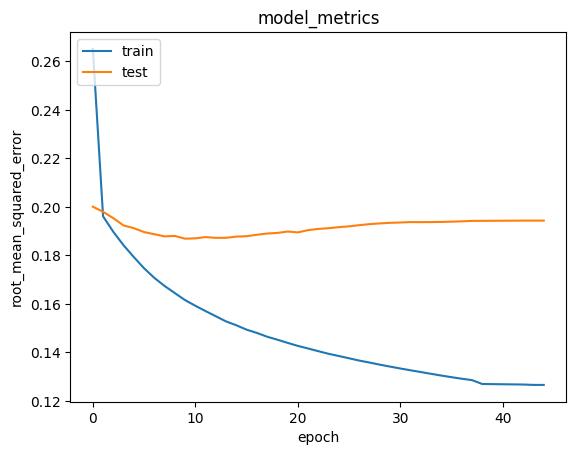

In [54]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Grafik di atas memvisualisasikan metrik RMSE pada data latih (*train*) dan data validasi (*test*) selama proses pelatihan model. Kurva biru (RMSE data latih) menunjukkan penurunan yang konsisten, menandakan bahwa model berhasil mempelajari pola dari data yang diberikan. Di sisi lain, kurva oranye (RMSE data validasi) menurun pada beberapa *epoch* awal sebelum menjadi stagnan dan kemudian sedikit meningkat. Kesenjangan (*gap*) yang semakin melebar antara kedua kurva ini merupakan indikasi terjadinya ***overfitting***, di mana model menjadi terlalu baik dalam mengenali data latih tetapi kehilangan kemampuannya untuk generalisasi pada data baru. Fenomena ini memvalidasi pentingnya penggunaan *callback* `EarlyStopping` yang telah menghentikan pelatihan pada waktu yang tepat.

### Perhitungan RMSE dan MAE pada Data Validasi

Untuk mengukur akurasi prediksi dari model yang telah dilatih, dilakukan evaluasi kuantitatif pada data validasi. Evaluasi ini menggunakan dua metrik regresi yang umum, yaitu **Mean Absolute Error (MAE)** dan **Root Mean Squared Error (RMSE)**. Kedua metrik ini akan menghitung tingkat kesalahan antara rating yang diprediksi oleh model dengan rating aktual pada skala yang telah dinormalisasi [0, 1].

1.  **Mean Absolute Error (MAE)**: Metrik ini menghitung rata-rata dari nilai absolut selisih antara prediksi dan nilai sebenarnya. MAE memberikan gambaran yang intuitif mengenai seberapa besar rata-rata kesalahan prediksi model. Formulanya adalah:

   $$MAE = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|$$

  Di mana nilai MAE yang lebih rendah menunjukkan model yang lebih baik.

2.  **Root Mean Squared Error (RMSE)**: Serupa dengan MAE, RMSE juga mengukur rata-rata kesalahan prediksi. Namun, karena RMSE mengkuadratkan selisih sebelum diakarkan, metrik ini memberikan bobot atau penalti yang lebih besar terhadap prediksi dengan kesalahan yang signifikan. Hal ini menjadikannya metrik yang baik untuk mengetahui adanya kesalahan besar (*large errors*) dalam prediksi model.

In [55]:
y_pred = model.predict(x_val).flatten()

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae  =     mean_absolute_error(y_val, y_pred)

print(f"⏱️ Evaluasi Prediksi Rating pada Data Validasi:")
print(f"    • RMSE: {rmse:.4f}")
print(f"    • MAE : {mae:.4f}")

934/934 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step
⏱️ Evaluasi Prediksi Rating pada Data Validasi:
    • RMSE: 0.1938
    • MAE : 0.1505


Berdasarkan hasil perhitungan pada data validasi, model ini mencapai performa dengan nilai sebagai berikut:
* **RMSE: 0.1938**
* **MAE : 0.1505**

Nilai-nilai ini dihitung pada skala rating yang telah dinormalisasi [0, 1] dan memberikan ukuran kuantitatif tingkat kesalahan prediksi model. Nilai **MAE sebesar 0.1505** menunjukkan bahwa secara rata-rata, prediksi rating yang dihasilkan oleh model memiliki selisih sekitar 0.15 dari rating aktual. Sementara itu, nilai **RMSE sebesar 0.1938**, yang sedikit lebih tinggi karena memberikan penalti lebih pada kesalahan besar, juga mengonfirmasi bahwa model memiliki tingkat akurasi yang baik.

### Evaluasi Model Menggunakan Precision@K, Recall@K, dan F1-Score@K

Selain akurasi prediksi rating yang diukur dengan RMSE dan MAE, evaluasi model rekomendasi juga perlu mengukur efektivitasnya dalam menyusun daftar peringkat item yang relevan bagi pengguna. Pada tahap ini, dilakukan evaluasi performa *top-N recommendation* untuk menguji seberapa baik model dapat menyajikan **10 buku teratas (K=10)** yang paling mungkin disukai.

Karena model menghasilkan prediksi rating dalam skala kontinu [0, 1], langkah pertama adalah menetapkan ambang batas (`RELEVANT_THRESHOLD`) untuk mendefinisikan sebuah buku sebagai "relevan" di data aktual. Berdasarkan analisis sebelumnya mengenai *trade-off* antara presisi dan recall, *threshold* kini diperketat. Dalam proyek ini, sebuah buku dianggap relevan jika pengguna memberikan rating **7 atau lebih tinggi** (pada skala asli 1-10), yang setara dengan nilai ternormalisasi sekitar **0.67**. Pilihan ini bertujuan untuk mengevaluasi kemampuan model dalam merekomendasikan buku-buku yang benar-benar berkualitas tinggi di mata pengguna.

Dengan definisi relevansi ini, tiga metrik utama akan dihitung untuk setiap pengguna dan kemudian dirata-ratakan:

* **Precision@10**: Metrik ini mengukur **ketepatan** dari daftar rekomendasi. Secara spesifik, metrik ini menghitung persentase item yang relevan dari 10 item teratas yang direkomendasikan. Nilai presisi yang tinggi menandakan bahwa rekomendasi di posisi atas sangat akurat.

* **Recall@10**: Metrik ini mengukur **cakupan** atau kelengkapan model. Metrik ini menghitung persentase item relevan yang berhasil ditemukan oleh model, dari keseluruhan item relevan yang sebenarnya ada untuk pengguna tersebut. Nilai recall yang tinggi menandakan model mampu menemukan kembali sebagian besar item yang disukai pengguna.

* **F1-Score@10**: Merupakan rata-rata harmonik yang menyeimbangkan antara presisi dan recall. Metrik ini memberikan gambaran performa yang lebih holistik, berguna karena seringkali terdapat *trade-off* antara menyajikan rekomendasi yang sangat akurat (presisi) dengan menemukan semua item yang relevan (recall).


In [61]:
RELEVANT_THRESHOLD = (7 - min_rating) / (max_rating - min_rating)
K = 10

y_pred = model.predict(x_val).flatten()

val_df = pd.DataFrame(x_val, columns=['user_encoded', 'book_encoded'])
val_df['pred_rating'] = y_pred
val_df['true_rating'] = y_val

val_df['is_relevant'] = val_df['true_rating'] >= RELEVANT_THRESHOLD

top_k_recommendations = (
    val_df.sort_values(by=['user_encoded', 'pred_rating'], ascending=[True, False])
    .groupby('user_encoded')
    .head(K)
)

precision_list = []
recall_list = []

for user_id, group in top_k_recommendations.groupby('user_encoded'):
    true_positives = group['is_relevant'].sum()

    total_relevant = val_df[(val_df['user_encoded'] == user_id) & (val_df['is_relevant'])].shape[0]

    precision = true_positives / K
    recall = true_positives / total_relevant if total_relevant > 0 else 0

    precision_list.append(precision)
    recall_list.append(recall)

avg_precision_at_k = np.mean(precision_list)
avg_recall_at_k = np.mean(recall_list)
if (avg_precision_at_k + avg_recall_at_k) > 0:
    avg_f1_at_k = 2 * (avg_precision_at_k * avg_recall_at_k) / (avg_precision_at_k + avg_recall_at_k)
else:
    avg_f1_at_k = 0.0

print(f"F1-Score@{K}: {avg_f1_at_k:.4f}")
print(f"Precision@{K}: {avg_precision_at_k:.4f}")
print(f"Recall@{K}: {avg_recall_at_k:.4f}")

934/934 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
F1-Score@10: 0.2448
Precision@10: 0.1444
Recall@10: 0.8020


Berdasarkan hasil perhitungan metrik evaluasi Top-N dari sel sebelumnya, kita mendapatkan:


* **Recall@10: 0.8020**
* **Precision@10: 0.1444**
* **F1-Score@10: 0.2448**

Berikut adalah interpretasi dari hasil ini:

-   Nilai **Recall@10 sebesar 80.2%** menunjukkan bahwa model masih sangat mampu menemukan sebagian besar buku yang sangat disukai pengguna (rating 7 atau lebih). Meskipun angka ini turun dibandingkan pengujian dengan threshold yang lebih rendah (rating ≥ 5), ini adalah hasil yang wajar karena target "sukses" sekarang jauh lebih sedikit dan lebih sulit untuk ditemukan. Namun, nilai di atas 80% tetap menunjukkan cakupan yang sangat baik.

-   Nilai **Precision@10 sebesar 14.4%** mengindikasikan bahwa dari 10 buku yang direkomendasikan, rata-rata hanya sekitar 1-2 buku yang memenuhi kriteria rating tinggi (≥ 7). Penurunan presisi ini menyoroti tantangan yang lebih besar bagi model: tidak hanya memprediksi rating tinggi, tetapi juga harus menempatkannya di peringkat paling atas, mengalahkan buku-buku lain yang mungkin juga memiliki prediksi rating yang cukup baik namun kini dianggap tidak relevan.

-   **F1-Score sebesar 0.2448** merefleksikan keseimbangan baru antara presisi yang lebih rendah dan recall yang masih tinggi. Skor F1-Score ini memberikan gambaran performa gabungan yang menunjukkan adanya *trade-off*: dengan standar kualitas yang lebih ketat, model saat ini lebih unggul dalam hal cakupan (*recall*) dibandingkan ketepatan (*precision*).

Secara keseluruhan, evaluasi dengan threshold yang lebih ketat ini memberikan pemahaman yang lebih dalam tentang perilaku model. Hasil ini menunjukkan bahwa model sangat efektif dalam mengidentifikasi hampir semua buku yang berpotensi sangat disukai pengguna, namun masih ada ruang untuk perbaikan dalam hal memprioritaskan rekomendasi terbaik di posisi teratas.

# Kesimpulan